In [46]:
!ls '/content/drive/MyDrive/Linear Regression - IA/CroppedTraining/'

no_tumor  yes_tumor


In [47]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import matplotlib.pyplot as plt
import tensorflow as tf
import argparse
import imutils
import time
import cv2

In [50]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

In [51]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [52]:
# Model Hyperparameters 
STEP_LEN   = 1e-4 
EPOCHS     = 5
BATCH_SIZE = 32 

In [53]:
train_dir = '/content/drive/MyDrive/Linear Regression - IA/CroppedTraining/'
CATEGORIES = ['no_tumor','yes_tumor']

# Pre-process and load dataset

In [54]:
data = []
labels = []

In [55]:
for category in CATEGORIES:
    path = os.path.join(train_dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size = (224,224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

In [56]:
# One-Hot Encoding labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data   = np.array(data, dtype = "float32")
labels = np.array(labels)

# Split dataset
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.20, stratify = labels, random_state = 42)

In [57]:
# Data Augmentation
aug = ImageDataGenerator(
    rotation_range = 20, #
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    fill_mode = "nearest")

# Deep Learning Model

In [58]:
baseModel = MobileNetV2(weights = "imagenet", include_top = False, input_tensor = Input(shape = (224, 224, 3)))

In [59]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name = "flatten")(headModel)
headModel = Dense(128, activation = "relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation = "softmax")(headModel)

model = Model(inputs = baseModel.input, outputs = headModel)

In [60]:
for layer in baseModel.layers:
	  layer.trainable = False

# Compile the model
opt = Adam(learning_rate = STEP_LEN, decay=STEP_LEN / EPOCHS)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

In [61]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size = BATCH_SIZE),
	steps_per_epoch  = len(trainX) // BATCH_SIZE,
	validation_data  = (testX, testY),
	validation_steps = len(testX) // BATCH_SIZE,
	epochs = EPOCHS)

Epoch 1/5
39/39 [==============================] - 23s 472ms/step - loss: 0.4399 - accuracy: 0.8570 - val_loss: 0.2965 - val_accuracy: 0.9137
Epoch 2/5
39/39 [==============================] - 13s 323ms/step - loss: 0.3193 - accuracy: 0.9154 - val_loss: 0.2737 - val_accuracy: 0.9137
Epoch 3/5
39/39 [==============================] - 13s 321ms/step - loss: 0.3042 - accuracy: 0.9129 - val_loss: 0.2640 - val_accuracy: 0.9137
Epoch 4/5
39/39 [==============================] - 13s 321ms/step - loss: 0.2737 - accuracy: 0.9129 - val_loss: 0.2573 - val_accuracy: 0.9137
Epoch 5/5
39/39 [==============================] - 13s 342ms/step - loss: 0.2800 - accuracy: 0.9088 - val_loss: 0.2493 - val_accuracy: 0.9137


In [62]:
# Predict the testing set
print("- [INFO] evaluating network...")
predictedIdxs = model.predict(testX, batch_size = BATCH_SIZE)
predictedIdxs = np.argmax(predictedIdxs, axis=1)
print(classification_report(testY.argmax(axis = 1), predictedIdxs, target_names = lb.classes_))

# Save the treined model to disk, can be a drive path.
print("- [INFO] saving treined model...")
model.save("/content/drive/MyDrive/Linear Regression - IA/tumor_detector.model", save_format="h5")

- [INFO] evaluating network...


10/10 [==============================] - 1s 39ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    no_tumor       0.91      1.00      0.95       286
   yes_tumor       0.00      0.00      0.00        27

    accuracy                           0.91       313
   macro avg       0.46      0.50      0.48       313
weighted avg       0.83      0.91      0.87       313

- [INFO] saving treined model...


# Using the Model

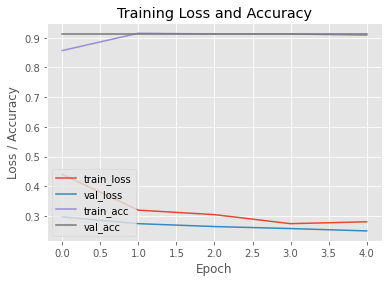

In [63]:
plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, EPOCHS), H.history["loss"],         label = "train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"],     label = "val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"],     label = "train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label = "val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc = "lower left")
plt.savefig("/content/drive/MyDrive/Linear Regression - IA/plot.png")

- [INFO] Loading trained model...


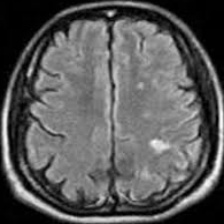

In [66]:
from google.colab.patches import cv2_imshow

print("- [INFO] Loading trained model...")
model = tf.keras.models.load_model('/content/drive/MyDrive/Linear Regression - IA/tumor_detector.model')

image = cv2.imread("/content/drive/MyDrive/Linear Regression - IA/CroppedTesting/no_tumor/0.jpg")
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = img_to_array(img)
img = preprocess_input(img)
img = np.expand_dims(img, axis=0)

cv2_imshow(image)

1/1 [==============================] - 1s 679ms/step


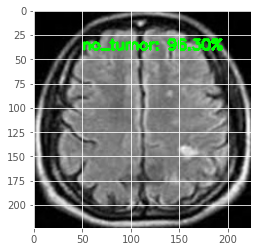

In [67]:
(no_tumor, yes_tumor) = model.predict(img)[0]

label = "no_tumor" if no_tumor > yes_tumor else "yes_tumor"
color = (0, 255, 0) if label == "no_tumor" else (0, 0, 255)
label = "{}: {:.2f}%".format(label, max(no_tumor, yes_tumor) * 100)

cv2.putText(image, label, (50, 50 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()